<a href="https://colab.research.google.com/github/flaviorv/pb_ai_ml/blob/main/tp3_pb_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (208, 61)
Synthetic data: 300
Grid Results:
    Train Acc  Val Acc  Comp  Depth  M. S. Leaf  M. S. Split
0        0.98     0.90     7      8           2            2
1        0.98     0.91     8      8           2            2
2        0.98     0.90     9      8           2            2
3        0.98     0.90     7      8           2            3
4        0.98     0.91     8      8           2            3
5        0.98     0.90     9      8           2            3
6        0.97     0.89     7      8           3            2
7        0.97     0.90     8      8           3            2
8        0.97     0.89     9      8           3            2
9        0.97     0.89     7      8           3            3
10       0.97     0.90     8      8           3            3
11       0.97     0.89     9      8           3            3
12       0.98     0.90     7      9           2            2
13       0.98     0.92     8      9           2            2
14       0.98     0.91    

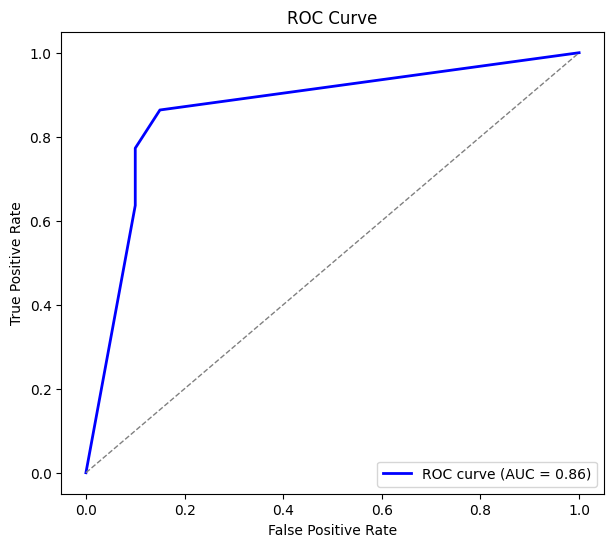

In [18]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Função para rodar o grid search, exibir as acurácias dos dados de treino e validação e retornar o modelo com a melhor
# configuração de hiperparâmetros
def grid_result(pipeline, grid_params, features, target, n_splits):
  # Questão 3 - Avaliação de Modelos: Aplicar técnicas de validação cruzada para estimar a eficiência dos modelos desenvolvidos.

  # Serão criados 5 folds, 4 para treino e 1 para validação. Eles irão trocar de papéis até que todos tenham tido pepel de fold
  # de validação. Dessa forma obtemos resultados mais generalistas. Evitando overfit (ter bons resultados com os dados de treino,
  # porém resultados bem abaixo com dados de fora do treino)
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # Questão 4 - Busca Hiperparamétrica: Utilizar GridSearch para otimizar os hiperparâmetros dos modelos.

  # O grid search utiliza a árvore de decisão e seus hiperparâmetros estão na variável grid_params
  grid = GridSearchCV(pipeline, grid_params, cv=skf, return_train_score=True)
  grid.fit(features, target)

  # Exibindo as acurácias de todos os modelos
  results = pd.DataFrame(columns=['Train Acc', 'Val Acc', 'Comp', 'Depth', 'M. S. Leaf', 'M. S. Split'])
  pd.set_option('display.float_format', '{:,.2f}'.format)
  results['Comp'] = grid.cv_results_['param_pca__n_components']
  results['Depth'] = grid.cv_results_['param_model__max_depth']
  results['M. S. Leaf'] = grid.cv_results_['param_model__min_samples_leaf']
  results['M. S. Split'] = grid.cv_results_['param_model__min_samples_split']
  results['Train Acc'] = grid.cv_results_['mean_train_score']
  results['Val Acc'] = grid.cv_results_['mean_test_score']

  print(f'Grid Results:\n{results}')
  # Exibindo e retornando o melhor modelo
  print(f'Best Params: {grid.best_params_}')

  return grid.best_estimator_, grid.cv_results_

# Carregando o Sonar dataset
sonar_df = pd.read_csv('https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/sonar_dataset.csv', header=None)
print('Dataset shape:', sonar_df.shape)

# Separando as fetures e o target
# Há 60 features. Elas representam dados retornados do sonar de submarinos
features = sonar_df.iloc[:, :-1]
# O target é composto por duas classes (M e R) que significam Mina e Rocha. Através dos dados do sonar de um submarino, o modelo deve tentar prever se é
# rocha ou mina que o sonar atingiu
target = sonar_df.iloc[:, -1]

# Dividindo o dataset entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, stratify=target, random_state=42)

# Como há apenas 208 amostras, foi necessário criar dados sintéticos para que o modelo fique mais generalista e não sofra de underfitting ou overfitting.
# Com datasets pequenos, ele pode aprender pouco, ou aprender demais sobre essas poucas amostras, fazendo com que perca a capacidade de generalizar
synthetic_data = 300
smote = SMOTE(sampling_strategy={'M': synthetic_data, 'R': synthetic_data}, random_state=42)
features_resampled, target_resampled = smote.fit_resample(x_train, y_train)
print('Synthetic data:', synthetic_data)

pipeline = Pipeline([
  # Questão 1 - Criação das features:Aplicar Análise de Componentes Principais (PCA) para reduzir a dimensionalidade dos conjuntos de dados.

  # O PCA ajuda a diminuir o ruído criando componentes que representam a maior variância. Ele também reduz o número de dimensões (para
  # datasets com muitas features isso é últil tornando o treino viável computacionalmente)
  ('pca', PCA(random_state=42)),
  # Questão 2 - Modelo de ML:  Desenvolver e treinar modelos de árvores de decisão para tarefas de classificação.

  # A árvore de decisão cria uma regra em cada nó para uma determinada feature. A regra que explica melhor o modelo fica no nó raiz.
  ('model', DecisionTreeClassifier(random_state=42))
])

# Questão 5 - Pruning de Árvores de Decisão: Realizar o pruning (poda) em árvores de decisão para prevenir o overfitting e melhorar a generalização do modelo.

# Através do hiperparâmetros max_depth, podemos limitar a profundidade da árvore, min_samples_leaf determina o número mínimo de amostras para ter em cada folha
# e min_samples_split o número mínimo de amostras para se criar um novo nó. Se a árvore crescer demais ela poderia gerar overfitting, criando muitas regras espe-
# cíficas para poucas amostras, sendo que essas amostras podem ser, inclusive, ruído.

# Hiperparâmetros
grid_params = {
    'pca__n_components': [7, 8, 9],
    'model__max_depth': [8, 9, 10],
    'model__min_samples_leaf': [2, 3],
    'model__min_samples_split': [2, 3]
}

# Resultados do grid search
result = grid_result(pipeline, grid_params, features_resampled, target_resampled, 6)

# Utilizando o melhor modelo nos dados de teste. Os dados de teste não são vistos pelo modelo no treinamento, evitando vazamento de informação,
# o que poderia gerar um modelo enviesado
y_pred = result[0].predict(x_test)

# Questão 6 - Avaliação de Classificadores Binários: Utilizar figuras de mérito como Curva ROC, precisão, recall, f1-score,
# sensibilidade e especificidade para avaliar os modelos.

# Obtendo precisão, recall(sensibilidade), acurácia e f1-score
# Recall e sensibilidade são a mesma coisa
print(classification_report(y_test, y_pred))

# Obtendo especificidade
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity0 = tp/(tp+fn)
specificity1 = tn/(tn+fp)

# Obtendo prabibilidades da classe positiva para cada amostra dos dados de teste
y_proba = result[0].predict_proba(x_test)[:, 0]

# Obtendo a taxa de Falsos Positivos e Verdadeiros Positivos para gerar a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label='M')
# Computando a área sob a curva
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC e a AUC
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Questão 7 - Baseado nos valores encontrados para as diferentes figuras de mérito, interprete os resultados e disserte sobre a eficiência
# do classificador criado.

# Tanto o PCA quanto o oversampler foram extremamente importantes, o PCA possivelmente tirando ruídos. Retirando apenas o PCA, o modelo
# atingiu valor bem abaixo de acurácia nos testes (76%). Retirando apenas os dados sintéticos, o modelo antingiu 71% de acurácia. Com os
# dois, o modelo atingiu 86%

# Através da curva AUC, podemos ver que o modelo tem um desempenho satisfatório para a maioria dos casos, para o caso de mina, não sei se ajustar
# o limite para melhorar o recall seria mais vantajoso. Porém com o resultado mostrado na curva ROC, pode-se ver que o modelo poderia se tornar
# inútil ao atingir o máximo de acurácia, pois teria muitos falsos positivos. Dessa forma, classificaria quase todos os dados que chegassem como mina

# Nos dados de treino o modelo se saiu bem melhor, chegando a 98% de acurácia, indicando que pode haver um certo overfitting, porém as métricas abaixo,
# foram as melhores alcançadas, testando variações de modelo. Talvez pelos dados do dataset, ou pelo modelo escolhido(árvore de decisão), isso tenha ocorrido.
# Random forest é menos propenso à overfitting